In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt

# PREPROCESSING

In [3]:
dataset = pd.read_csv("Live.csv").drop(columns = {'status_id','Column1','Column2','Column3','Column4'})
dataset['status_type'].value_counts()
dataset['status_published'] = dataset['status_published'].astype(str).str.replace("/","-")
dataset['status_published'] = pd.to_datetime(dataset['status_published'])

In [4]:
dataset.head()

,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,video,2018-04-22 06:00:00,529,512,262,432,92,3,1,1,0
1,photo,2018-04-21 22:45:00,150,0,0,150,0,0,0,0,0
2,video,2018-04-21 06:17:00,227,236,57,204,21,1,1,0,0
3,photo,2018-04-21 02:29:00,111,0,0,111,0,0,0,0,0
4,photo,2018-04-18 03:22:00,213,0,0,204,9,0,0,0,0


In [5]:
dataset['day'] = dataset['status_published'].dt.day
dataset['month'] = dataset['status_published'].dt.month
dataset['hour'] = dataset['status_published'].dt.hour
dataset['minute'] = dataset['status_published'].dt.minute

In [6]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
dataset['status_type'] = encoder.fit_transform(dataset['status_type'])

dataset = dataset.drop(columns = {'status_published'})

In [7]:
dataset.head()

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,day,month,hour,minute
0,3,529,512,262,432,92,3,1,1,0,22,4,6,0
1,1,150,0,0,150,0,0,0,0,0,21,4,22,45
2,3,227,236,57,204,21,1,1,0,0,21,4,6,17
3,1,111,0,0,111,0,0,0,0,0,21,4,2,29
4,1,213,0,0,204,9,0,0,0,0,18,4,3,22


reduzindo a dimensionalidade

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X = pca.fit_transform(dataset)
explained_variance = pca.explained_variance_ratio_

In [9]:
explained_variance.sum()

0.9900316764241575

In [10]:
X

array([[ 372.69830115,  308.23995398],
       [-242.60414041,  -59.76208396],
       [  11.51216706,  -11.73244031],
       ...,
       [-281.03712429, -266.13524899],
       [-176.79506927,  216.13990972],
       [-277.08346764, -244.58325588]])

vemos que o PCA nesse caso foi de grande utilidade, visto que transformou um dataframe com dimensão 10 em um de 2 dimensões preservando a variância quase que por completo

# Inicializando com K-means++ 

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

vamos variar o número de clusters do KMeans e ver como varia o wcss (within-cluster sums of squares)

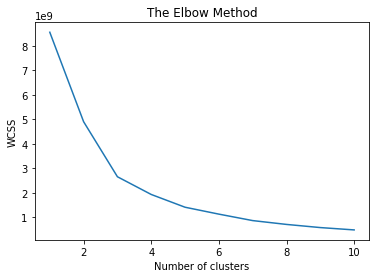

In [12]:
wcss = []
for i in range(1, 11):
    kmeansPP = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeansPP.fit(X)
    wcss.append(kmeansPP.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

É visível que o decaimento do WCSS começa a ser mais discreto quando o número de clusters passa de 4, mas fica difícil distinguir se o número certo seria 3 ou 4 clusters. Para isso vamos utilizar da silhouette score para desempatar entre esses dois

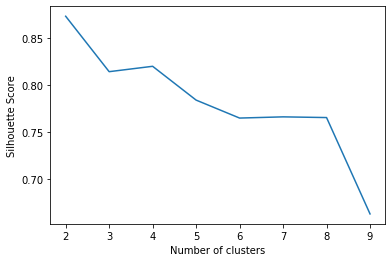

[0.8730734506785333, 0.8142405857867846, 0.8199480066503121, 0.7840782113944493, 0.7650059521977578, 0.7662845017976804, 0.7655413281587189, 0.6632710096674763]


In [13]:
sil = []
for i in range(2, 10):
    kmeansPP = KMeans(n_clusters = i, init = 'k-means++', random_state = 0).fit(X)
    labels = kmeansPP.labels_
    sil.append(silhouette_score(X, labels, metric = 'euclidean'))
    #print(sil)
plt.plot(range(2, 10), sil)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()
print(sil)

a sihlouette score do 4 ficou maior, logo, ficaremos com o valor de 4 clusters

In [21]:
kmeansPP = KMeans(n_clusters = 4, init = 'k-means++', random_state = 29)
y_kmeansPP = kmeansPP.fit_predict(X)

In [22]:
pd.DataFrame(y_kmeansPP)[0].value_counts()

0    6327
1     460
2     223
3      40
Name: 0, dtype: int64

In [23]:
y_kmeansPP

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

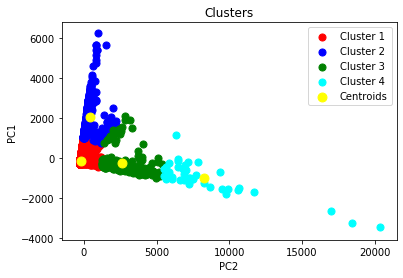

In [24]:
plt.figure(2)
plt.scatter(X[y_kmeansPP == 0, 0], X[y_kmeansPP == 0, 1], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeansPP == 1, 0], X[y_kmeansPP == 1, 1], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeansPP == 2, 0], X[y_kmeansPP == 2, 1], s = 50, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_kmeansPP == 3, 0], X[y_kmeansPP == 3, 1], s = 50, c = 'cyan', label = 'Cluster 4')
#plt.scatter(X[y_kmeansPP == 4, 0], X[y_kmeansPP == 4, 1], s = 50, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeansPP.cluster_centers_[:, 0], kmeansPP.cluster_centers_[:, 1], s = 80, c = 'yellow', label = 'Centroids')
plt.title('Clusters')
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.legend()
plt.show()

# Inicializando aleatoriamente 

vamos variar o número de clusters do KMeans e ver como varia o wcss (within-cluster sums of squares)

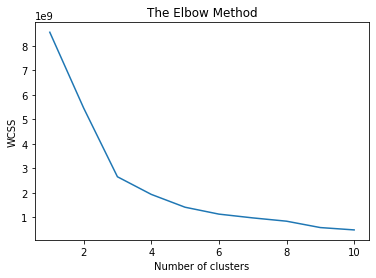

In [86]:
wcss = []
for i in range(1, 11):
    kmeansR= KMeans(n_clusters = i, init = 'random', random_state = 42)
    kmeansR.fit(X)
    wcss.append(kmeansR.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

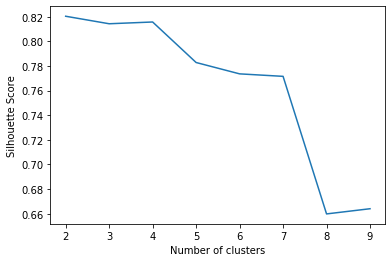

[0.8203410223957377, 0.8142405857867845, 0.8156717991900972, 0.7827751571376436, 0.7735590977776858, 0.7715383824562414, 0.6598408656503573, 0.6640528526082106]


In [87]:
sil = []
for i in range(2, 10):
    kmeansR = KMeans(n_clusters = i, init = 'random', random_state = 42).fit(X)
    labels = kmeansR.labels_
    sil.append(silhouette_score(X, labels, metric = 'euclidean'))
    #print(sil)
plt.plot(range(2, 10), sil)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()
print(sil)

É visível que o decaimento do WCSS começa a ser mais discreto quando o número de clusters passa de 4

In [88]:
kmeansR = KMeans(n_clusters = 4, init = 'random', random_state = 42)
y_kmeansR = kmeansR.fit_predict(X)

In [89]:
pd.DataFrame(y_kmeansR)[0].value_counts()

1    6255
2     426
3     311
0      58
Name: 0, dtype: int64

In [90]:
y_kmeansR

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

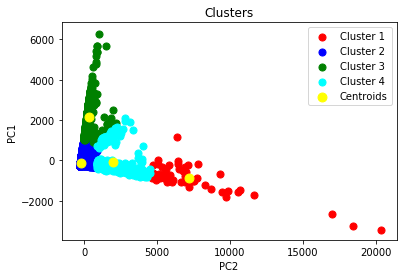

In [91]:
plt.figure(2)
plt.scatter(X[y_kmeansR == 0, 0], X[y_kmeansR == 0, 1], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeansR == 1, 0], X[y_kmeansR == 1, 1], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeansR == 2, 0], X[y_kmeansR == 2, 1], s = 50, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_kmeansR == 3, 0], X[y_kmeansR == 3, 1], s = 50, c = 'cyan', label = 'Cluster 4')
#plt.scatter(X[y_kmeansR == 4, 0], X[y_kmeansR == 4, 1], s = 50, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeansR.cluster_centers_[:, 0], kmeansR.cluster_centers_[:, 1], s = 80, c = 'yellow', label = 'Centroids')
plt.title('Clusters')
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.legend()
plt.show()

Assim ficou a distribuição do nosso cluster com KMeans inicializado aleatoriamente.

# Comparando os Kmeans 

In [92]:
pd.Series(y_kmeansPP).value_counts()

0    6327
3     460
2     223
1      40
dtype: int64

In [93]:
pd.Series(y_kmeansR).value_counts()

1    6255
2     426
3     311
0      58
dtype: int64

Podemos ver que tirando o fato que o algoritmo tenha dado nomes diferentes aos clusters, podemos ver no gráfico que eles se localizam na mesma região e possuem a mesma forma, com pequenas diferenças no número de pontos dentro deles

In [94]:
np.set_printoptions(suppress=True)

kmeansR.cluster_centers_.sort()

In [95]:
kmeansR.cluster_centers_

array([[7228.53843796, -886.5113629 ],
       [-188.89865284, -133.97912318],
       [ 324.06500219, 2128.44973919],
       [1993.21519439,  -56.00789961]])

kmeansPP.cluster_centers_.sort()

In [96]:
kmeansPP.cluster_centers_

array([[-173.77943333, -134.99741838],
       [8237.89495414, -996.11186789],
       [2640.49366501, -226.22325987],
       [ 393.81867216, 2053.08897341]])

os centros permanecem próximos nos dois exemplos

# Normalizando os dados e tentando novamente 

In [97]:
X

array([[ 372.69830115,  308.23995398],
       [-242.60414041,  -59.76208396],
       [  11.51216706,  -11.73244031],
       ...,
       [-281.03712429, -266.13524899],
       [-176.79506927,  216.13990972],
       [-277.08346764, -244.58325588]])

In [98]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [99]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [100]:
X_scaled = scaler.fit_transform(X)

In [101]:
X_scaled

array([[-0.93671722, -0.2275272 ],
       [-0.99623523, -0.3033381 ],
       [-0.97165464, -0.29344367],
       ...,
       [-0.99995284, -0.34585237],
       [-0.98986954, -0.24650043],
       [-0.9995704 , -0.34141251]])

# Kmeans ++ scaled

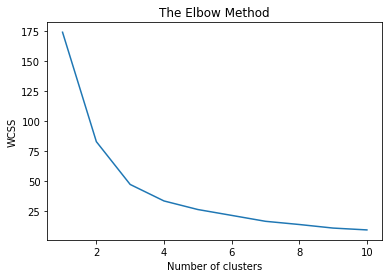

In [135]:
wcss = []
for i in range(1, 11):
    kmeansPPScaled = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeansPPScaled.fit(X_scaled)
    wcss.append(kmeansPPScaled.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

É visível que o decaimento do WCSS começa a ser mais discreto quando o número de clusters passa de 4

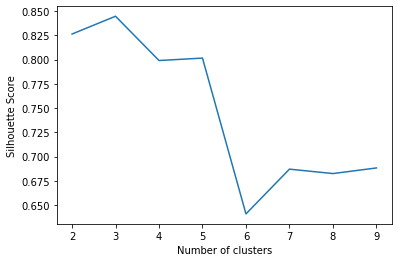

[0.8264457410479821, 0.8447858590704375, 0.7991111074105037, 0.8016084796125983, 0.6408442795198294, 0.6870467676446916, 0.6824744270214161, 0.6882682879930548]


In [136]:
sil = []
for i in range(2, 10):
    kmeansPPScaled = KMeans(n_clusters = i, init = 'k-means++', random_state = 42).fit(X_scaled)
    labels = kmeansPPScaled.labels_
    sil.append(silhouette_score(X_scaled, labels, metric = 'euclidean'))
    #print(sil)
plt.plot(range(2, 10), sil)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()
print(sil)

In [137]:
kmeansPPScaled = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeansPPScaled = kmeansPPScaled.fit_predict(X_scaled)

In [138]:
pd.DataFrame(y_kmeansPPScaled)[0].value_counts()

0    6430
1     483
2     137
Name: 0, dtype: int64

In [139]:
y_kmeansPPScaled

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

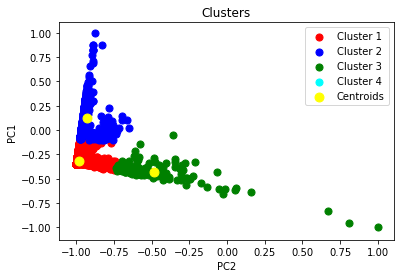

In [140]:
plt.figure(3)
plt.scatter(X_scaled[y_kmeansPPScaled == 0, 0], X_scaled[y_kmeansPPScaled == 0, 1], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(X_scaled[y_kmeansPPScaled == 1, 0], X_scaled[y_kmeansPPScaled == 1, 1], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(X_scaled[y_kmeansPPScaled == 2, 0], X_scaled[y_kmeansPPScaled == 2, 1], s = 50, c = 'green', label = 'Cluster 3')
plt.scatter(X_scaled[y_kmeansPPScaled == 3, 0], X_scaled[y_kmeansPPScaled == 3, 1], s = 50, c = 'cyan', label = 'Cluster 4')
#plt.scatter(X_scaled[y_kmeansPPScaled == 4, 0], X_scaled[y_kmeansPPScaled == 4, 1], s = 50, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeansPPScaled.cluster_centers_[:, 0], kmeansPPScaled.cluster_centers_[:, 1], s = 80, c = 'yellow', label = 'Centroids')
plt.title('Clusters')
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.legend()
plt.show()

# Random scaled 

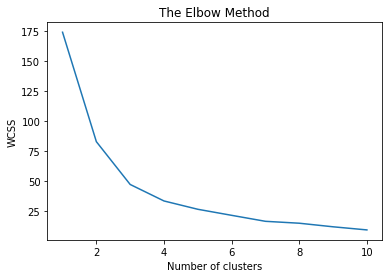

In [141]:
wcss = []
for i in range(1, 11):
    kmeansRscaled= KMeans(n_clusters = i, init = 'random', random_state = 42)
    kmeansRscaled.fit(X_scaled)
    wcss.append(kmeansRscaled.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

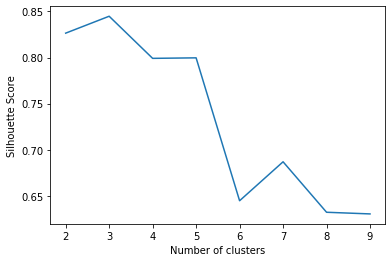

[0.8264457410479821, 0.8447858590704375, 0.7991111074105037, 0.7996718086052876, 0.6447061235571588, 0.6869526656399368, 0.6322110444131382, 0.6304166343219358]


In [142]:
sil = []
for i in range(2, 10):
    kmeansRscaled = KMeans(n_clusters = i, init = 'random', random_state = 42).fit(X_scaled)
    labels = kmeansRscaled.labels_
    sil.append(silhouette_score(X_scaled, labels, metric = 'euclidean'))
    #print(sil)
plt.plot(range(2, 10), sil)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()
print(sil)

É visível que o decaimento do WCSS começa a ser mais discreto quando o número de clusters passa de 5

In [143]:
kmeansRscaled = KMeans(n_clusters = 3, init = 'random', random_state = 42)
y_kmeansRscaled = kmeansRscaled.fit_predict(X_scaled)

In [144]:
pd.DataFrame(y_kmeansRscaled)[0].value_counts()

1    6430
2     483
0     137
Name: 0, dtype: int64

In [145]:
y_kmeansRscaled

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

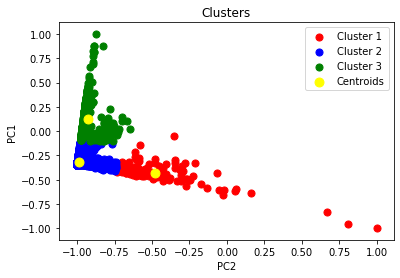

In [146]:
plt.figure(2)
plt.scatter(X_scaled[y_kmeansRscaled == 0, 0], X_scaled[y_kmeansRscaled == 0, 1], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(X_scaled[y_kmeansRscaled == 1, 0], X_scaled[y_kmeansRscaled == 1, 1], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(X_scaled[y_kmeansRscaled == 2, 0], X_scaled[y_kmeansRscaled == 2, 1], s = 50, c = 'green', label = 'Cluster 3')
#plt.scatter(X_scaled[y_kmeansRscaled == 3, 0], X_scaled[y_kmeansRscaled == 3, 1], s = 50, c = 'cyan', label = 'Cluster 4')
#plt.scatter(X[y_kmeansR == 4, 0], X[y_kmeansR == 4, 1], s = 50, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeansRscaled.cluster_centers_[:, 0], kmeansRscaled.cluster_centers_[:, 1], s = 80, c = 'yellow', label = 'Centroids')
plt.title('Clusters')
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.legend()
plt.show()

Nas duas observações feitas com os dados normalizados, encontramos o número de clusters sendo 3

# Comparando todos os resultados finais

In [147]:
print(kmeansPP.cluster_centers_)
pd.Series(y_kmeansPP).value_counts()

[[-173.77943333 -134.99741838]
 [8237.89495414 -996.11186789]
 [2640.49366501 -226.22325987]
 [ 393.81867216 2053.08897341]]


0    6327
3     460
2     223
1      40
dtype: int64

In [148]:
print(kmeansR.cluster_centers_)
pd.Series(y_kmeansR).value_counts()

[[7228.53843796 -886.5113629 ]
 [-188.89865284 -133.97912318]
 [ 324.06500219 2128.44973919]
 [1993.21519439  -56.00789961]]


1    6255
2     426
3     311
0      58
dtype: int64

In [149]:
print(kmeansPPScaled.cluster_centers_)
pd.Series(y_kmeansPPScaled).value_counts()

[[-0.98661691 -0.31935408]
 [-0.92739326  0.12481535]
 [-0.48276022 -0.42757209]]


0    6430
1     483
2     137
dtype: int64

In [150]:
print(kmeansRscaled.cluster_centers_)
pd.Series(y_kmeansRscaled).value_counts()

[[-0.48276022 -0.42757209]
 [-0.98661691 -0.31935408]
 [-0.92739326  0.12481535]]


1    6430
2     483
0     137
dtype: int64

os resultados deram iguais para os dois depois do scale